In [1]:
from netCDF4 import Dataset
from wrf import getvar,interplevel,ll_to_xy, smooth2d
import xarray as xr
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cartopy.feature as cfe

import pandas as pd
%matplotlib inline


## Lectura de los datos 
De meteo blue

In [2]:
df_prueba_temperatura = pd.read_csv("/home/fernan/Downloads/data_11_18_05.csv")[::]
t_1 = df_prueba_temperatura["temperatura"]

Datos de NCAAA con temperatura y presión

In [3]:
df_wrf = pd.read_csv("/home/fernan/Downloads/datoa_semana_11_18.csv")
df_wrf= df_wrf.drop(columns=["Hora"],axis=1)

Datos NCAAA con la dirección y la velocidad del viento

In [4]:
df_Dir_Viento = pd.read_csv("Dator_Dir_Viento.csv").transpose()
df_Dir_Viento=df_Dir_Viento.rename(columns=df_Dir_Viento.iloc[0])[1:-3]

In [5]:
df_Vel_Viento = pd.read_csv("Dator_Vel_Viento.csv").transpose()
df_Vel_Viento=df_Vel_Viento.rename(columns=df_Vel_Viento.iloc[0])[1:-3]


## Validación de la temperatura a 2 metros 
### Aeropuerto de Madrid Barajas

Obtenemos las coordenadas en nuestro grid

In [6]:
ncfile = Dataset('wrfout_d02_2021-05-11_00:00:00')
ll_to_xy(ncfile,latitude = 40.45, longitude = -3.55)


<xarray.DataArray 'xy' (x_y: 2)>
array([30, 28])
Coordinates:
    latlon_coord  object CoordPair(lat=40.45, lon=-3.55)
  * x_y           (x_y) <U1 'x' 'y'

Creamos un vector con nuestra temperatura a 2 metros

In [7]:
v_t2 =[]
for i in range(0,168):
    t2 = getvar(ncfile, 'T2', timeidx=i)
    v_t2.append(float(t2[13][15])-273.15)

### Calcular el coeficiente de correlación con los datos de Meteoblue

Calcular el coeficiente de correlación:

In [8]:
correlation_matrix = np.corrcoef(np.array(v_t2),np.array(t_1))

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2
r_squared

0.8444702611924523

Text(0, 0.5, 'Temperatura(C)')

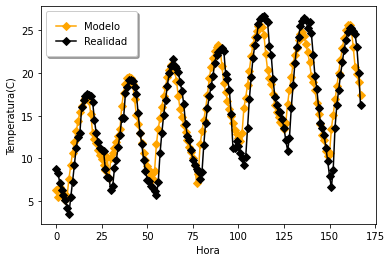

In [9]:
plt.plot(range(0,len(v_t2)),v_t2, '-D',color= "orange",label = "Modelo")
plt.plot(range(0,len(v_t2)), t_1, '-D',color = "black",label = "Realidad")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Hora')
plt.ylabel('Temperatura(C)')

### Calcular el coeficiente de correlación con los datos de NCAAA

In [10]:
t = df_wrf.TEMPERATURE_2M_DEGC


In [11]:
correlation_matrix = np.corrcoef(np.array(v_t2[::3]),np.array(t[:-2]))

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2
r_squared

0.8236874516540372

Text(0, 0.5, 'Temperatura(C)')

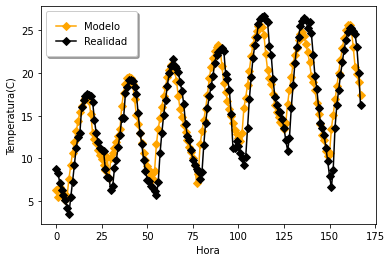

In [12]:
plt.plot(range(0,len(v_t2)),v_t2, '-D',color= "orange",label = "Modelo")
plt.plot(range(0,len(v_t2)), t_1, '-D',color = "black",label = "Realidad")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Hora')
plt.ylabel('Temperatura(C)')

## Validación presión

In [13]:
v_presion =[]
for i in range(0,169,3):
    slp = getvar(ncfile, 'slp', timeidx=i)
    v_presion.append(float(slp[13][15]))
presion_modelo = np.array(v_presion)


In [14]:
correlation_matrix = np.corrcoef(presion_modelo,np.array(df_wrf.MSLPRESSURE_HPA[:-1]))

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2
r_squared

0.831881762437603

Text(0, 0.5, 'Temperatura(C)')

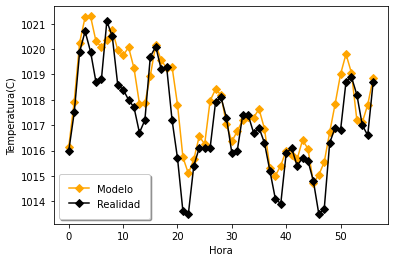

In [15]:
plt.plot(range(0,len(presion_modelo)),presion_modelo, '-D',color= "orange",label = "Modelo")
plt.plot(range(0,len(presion_modelo)), np.array(df_wrf.MSLPRESSURE_HPA[:-1]), '-D',color = "black",label = "Realidad")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Hora')
plt.ylabel('Presión(C)')

## Validación vientos

### Dirección del viento 

In [16]:
v_vient =[]
v_vel_viento = []
for i in range(0,169):
    uvmet = getvar(ncfile, "uvmet_wspd_wdir", units="kt",timeidx=i)
    p = getvar(ncfile, "pressure",timeidx=i)
    
    uvmet= smooth2d(uvmet, 3, cenweight=4)
    
    #Para interpolar a esta altura

    
    va =interplevel(uvmet[1,:], p, 925)[13][15]

    va = va   if va>100 else 360+va
    
    spd =  interplevel(uvmet[0,:], p, 925)[13][15]

    v_vient.append(int(va))
    v_vel_viento.append(float(spd))
    
    
dir_viento_modelo = np.array(v_vient)

#Para pasar de m/s a nudos
vel_viento_modelo = np.array(v_vel_viento)

In [17]:
correlation_matrix = np.corrcoef(dir_viento_modelo[::3],np.array(df_Dir_Viento["925.mb"][:]).astype('float64'))

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2
r_squared

0.5982581494081102

<function matplotlib.pyplot.show(close=None, block=None)>

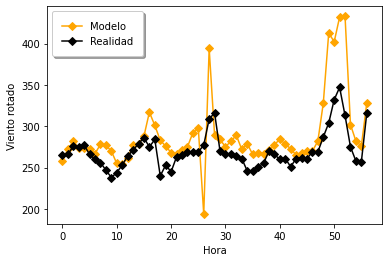

In [18]:
plt.plot(range(0,len(dir_viento_modelo[::3])),dir_viento_modelo[::3], '-D',color= "orange",label = "Modelo")
plt.plot(range(0,len(dir_viento_modelo[::3])), np.array(df_Dir_Viento["925.mb"][:]).astype('float64'), '-D',color = "black",label = "Realidad")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Hora')
plt.ylabel('Viento rotado')
plt.show

### Velocidad viento

In [19]:
correlation_matrix = np.corrcoef(v_vel_viento[::3],np.array(df_Vel_Viento["925.mb"]).astype('float64'))

correlation_xy = correlation_matrix[0,1]

r_squared = correlation_xy**2
r_squared

0.5024580647176368

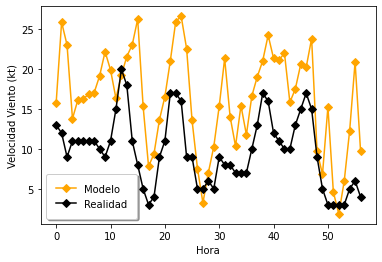

In [20]:
plt.plot(range(0,len(vel_viento_modelo[::3])),vel_viento_modelo[::3] , '-D',color= "orange",label = "Modelo")
plt.plot(range(0,len(np.array(df_Vel_Viento["925.mb"]).astype('float64'))), np.array(df_Vel_Viento["925.mb"]).astype('float64'), '-D',color = "black",label = "Realidad")
plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
plt.xlabel('Hora')
plt.ylabel('Velocidad Viento (kt)')
plt.show()